In [1]:
!cp /content/drive/MyDrive/University/Junior/DataStructure_Project/integration/NN.py .
!cp /content/drive/MyDrive/University/Junior/DataStructure_Project/integration/nets.py .
!cp /content/drive/MyDrive/University/Junior/DataStructure_Project/integration/Model.py .
!cp /content/drive/MyDrive/University/Junior/DataStructure_Project/integration/Adam.py .

In [2]:
import numpy as np
from tqdm import tqdm
import gym
gym.logger.set_level(40) # To mute unneeded warnings
from nets import *
import cv2
from glob import glob
from NN import *
from matplotlib import pyplot as plt

In [4]:
# !sudo apt-get install build-essential python-dev swig python-pygame
!pip install box2d-py
!pip3 install box2d box2d-kengz

  Using cached https://files.pythonhosted.org/packages/81/20/51d6c0c87f7642efb709c518fb0ca8e5eab068259588552c41da5926ae27/Box2D-kengz-2.3.3.tar.gz
  ERROR: Failed building wheel for box2d-kengz
  Running setup.py clean for box2d-kengz
Failed to build box2d-kengz
    Running setup.py install for box2d-kengz ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-sfl06pum/box2d-kengz/setup.py'"'"'; __file__='"'"'/tmp/pip-install-sfl06pum/box2d-kengz/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-dl1gni7r/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [12]:
class Params:
    def __init__(self,model_name, env_name,solved_at=np.inf,export_video=None,num_episodes=2000,export_video_every=None):
        self.env_name = env_name                  # Name of the environment to learn
        self.solved_at = solved_at                # The rewards to stop training at when reached
        self.export_video = export_video          # Path to export video to (exported every log_episode_interval episodes)
        self.export_video_every = export_video_every # If not None, will record video every this num episodes instead of log_episode_interval
        self.num_episodes = num_episodes          # Max number of episodes to play
        self.max_steps_per_episode = 2000         # Max number of steps per episode
        self.log_episode_interval = 10            # Print some info every (log_episode_interval) episodes
        self.update_nets_period = 512            # Update the policy and value nets using PPO every this number of steps/frames
        self.ppo_clipping = 0.2                   # PPO clipping parameter
        self.policy_lr = 0.002                    # Learning rate for the policy net
        self.value_lr = 0.002                     # Learning rate for the value net
        self.use_cuda = False                     # use_cuda=True => will use GPU for training, only recommended for CNNs
        self.ppo_training_num_epochs = 4          # Number of training epochs in the PPO train
        self.entropy_beta = 0.01                  # Factor multiplied by the entropy in the ppo_loss
        self.gamma = 0.99                         # Discount factor using in MDPs
        self.hidden_layer_size = 64               # Size of the hidden layer used in the policy and value nets
        self.action_var = 0.25                    # Variance of the action (only used for continuous action space environments)
        self.font_size = 0.8
        self.font_color = (20,20,255)
        self.font_margin = 50
        self.modelType = model_name
        self.A2C_training_num_epochs = 1 

In [13]:
class Trainer:
    def __init__(self,params):
        self.params = params
        self.data = []
        self.env = gym.make(params.env_name)
        self.env.spec.max_episode_steps = params.max_steps_per_episode+1
        if params.export_video is not None:
            video_callable = lambda x: x%params.log_episode_interval==0
            if params.export_video_every is not None:
                video_callable = lambda x: x%params.export_video_every==0
            self.env = gym.wrappers.Monitor(self.env,params.export_video,video_callable=video_callable,force=True)
        
        self.state_space = np.array(self.env.observation_space.shape)

        if 'n' in self.env.action_space.__dict__: # Discrete Action Space
            self.action_space = self.env.action_space.n
            self.continuous = False
        else:                            # Continuous Action Space
            self.action_space = self.env.action_space.shape[0]
            self.action_var = np.full((self.action_space,), self.params.action_var)
            self.cov_mat = np.diag(self.action_var)
            self.continuous = True

        if (params.modelType == "PPO" or params.modelType == "A2C"):
          self.policy_net = Policy_Net(self.state_space,self.action_space,params.policy_lr,self.continuous,params.hidden_layer_size)
          self.value_net = Value_Net(self.state_space,params.value_lr,params.hidden_layer_size)
        else:
          self.policy_net = Policy_Net_Relu(self.state_space,self.action_space,params.policy_lr,self.continuous,params.hidden_layer_size)
          self.value_net = Value_Net_Relu(self.state_space,params.value_lr,params.hidden_layer_size)
        self.memory = {
            'states':[],
            'rewards':[],
            'actions':[],
            'log_probs':[],
            'masks':[],
            'log_probs' :[],
             'preds' : [],
             "vals" : []
        }

        self.episode_rewards = []

    def process_state(self,state):
        if len(self.state_space)==1:
            return np.array(state,dtype=np.float).reshape(-1,self.state_space[0])
        else:
            state = torch.tensor(state.copy()).type(torch.FloatTensor)
            state = state.reshape(1,*self.state_space[[2,0,1]]).cpu().detach().numpy()
            return state
    def clear_memory(self):
      self.memory = {
            'states':[],
            'rewards':[],
            'actions':[],
            'log_probs':[],
            'masks':[],
            'log_probs' :[],
             'preds' : [],
             "vals" : []
        }
    def ppo_train(self):
        returns = []
        disc_reward = 0
        for mask,reward in zip(reversed(self.memory['masks']),reversed(self.memory['rewards'])):
            disc_reward = reward + self.params.gamma*disc_reward*mask
            returns.append(disc_reward)

        returns  = np.array(returns[::-1],dtype=np.float)
        returns = (returns-np.mean(returns))/(np.std(returns)+1e-8)
        states = np.array(self.memory['states']).reshape(-1,self.state_space[0])
        actions = np.array(self.memory['actions'])
        actions_hot = np.ones((actions.shape[0],self.action_space))
        if not self.continuous:
            actions = np.array(actions,dtype=np.int)
            actions_hot = np.eye(self.action_space)[actions.reshape(-1)]

        log_probs = np.array(self.memory['log_probs']).reshape(-1,1) # Shape = (batch_size,1)
        for ppo_epoch in range(self.params.ppo_training_num_epochs):
            # Zero-ing out gradients of policy and value nets
            self.policy_net.zero_grad()
            self.value_net.zero_grad()
            
            policy_pred = self.policy_net.forward(states) # Shape = (batch_size,self.action_space)
            vals = self.value_net.forward(states) # Shape = (batch_size,1)

            if self.continuous:
                new_action_logprobs = calc_log_prob_multi_normal(policy_pred,self.cov_mat,actions).reshape(-1,1)
                back_entropy = 0
            else:
                new_action_logprobs = np.sum(actions_hot*np.log(policy_pred),axis=1).reshape(-1,1) # Shape = (batch_size,1)
                back_entropy = (np.log(policy_pred)+1)*self.params.entropy_beta # Shape = (batch_size,action_space)
                
            # Calculating PPO Loss
            ratios = np.exp(new_action_logprobs-log_probs) # Shape = (batch_size,1)
            advantages = returns.reshape(-1,1) - vals # Shape = (batch_size,1)
            
            dratios_dp = (ratios*actions_hot)/(policy_pred+1e-7) # Shape = (batch_size,action_space)
            p1 = ratios*advantages # Shape = (batch_size,1)
            dp1_dp = dratios_dp*advantages # Shape = (batch_size,action_space)
            p2 = np.clip(ratios,1-self.params.ppo_clipping,1+self.params.ppo_clipping)*advantages # Shape = (batch_size,1)
            dp2_dp = dratios_dp*advantages*np.logical_and(ratios>1-self.params.ppo_clipping, ratios<1+self.params.ppo_clipping) # Shape = (batch_size,action_space)
            is_p1 = np.array(p1 <= p2,dtype=np.int) # Shape = (batch_size,1)
            dppo_dp = back_entropy-dp1_dp*is_p1-dp2_dp*(1-is_p1)

            # Backprop PPO loss into the policy and value nets
            self.value_net.backward(-10000*advantages/advantages.shape[0])
            self.policy_net.backward(10000*dppo_dp/(dppo_dp.shape[0]))
            
            # Optimize the policy and value networks
            self.policy_net.optimize()
            self.value_net.optimize()

        # Clear the memory after training is complete
        self.clear_memory()
    def discounted_rewards(self,T_rewards):
      gamma = 0.99
      gvals = []
      q = 0
      for r in reversed(range(len(T_rewards))):
        q= r + q *gamma
        gvals.append(q)
      gvals.reverse()
      re = np.array(gvals ,dtype=np.float64).reshape(-1,1)
      return re/100
    def reinforce_train(self):
      actions = np.array(self.memory["actions"],dtype=np.int)
      OHE = np.ones((actions.shape[0],self.action_space))
      OHE = np.eye(self.action_space)[actions.reshape(-1)]
      discountedRewards = self.discounted_rewards(np.array(self.memory["rewards"]))
      self.policy_net.zero_grad()
      pred = self.policy_net.forward(np.array(self.memory["states"]).reshape(-1,self.state_space[0]))
      dloss = discountedRewards/(np.array(self.memory["preds"],dtype=np.float64).reshape(-1,1))
      self.policy_net.backward(-(dloss) * OHE)
      self.policy_net.optimize()
      self.clear_memory()
    
    def A2C_train(self):
      self.policy_net.zero_grad()
      self.value_net.zero_grad()
      pred = self.policy_net.forward(np.array(self.memory["states"]).reshape(-1,self.state_space[0]))
      vals = self.value_net.forward(np.array(self.memory["states"]).reshape(-1,self.state_space[0]))
      actions = np.array(self.memory["actions"],dtype=np.int)
      OHE = np.ones((actions.shape[0],self.action_space))
      OHE = np.eye(self.action_space)[actions.reshape(-1)]
      discountedRewards = self.discounted_rewards(np.array(self.memory["rewards"]))
      advantage = discountedRewards - vals.reshape(-1,1)
      policy_dloss = advantage/(np.array(self.memory["preds"],dtype=np.float64).reshape(-1,1))
      value_dloss = advantage
      self.policy_net.backward(-(policy_dloss) * OHE)
      self.value_net.backward(-value_dloss)
      self.policy_net.optimize()
      self.value_net.optimize()
      self.clear_memory()
    
    def play_and_train(self,record_every=0):
        total_reward = 0
        avg_length = 0
        for e in range(1,self.params.num_episodes+1):
            episode_reward = 0
            current_state = self.process_state(self.env.reset())
            for t in range(self.params.max_steps_per_episode):
                policy_pred = self.policy_net.forward(current_state)

                if self.continuous:
                    action = np.random.multivariate_normal(policy_pred[0], self.cov_mat,1)[0]
                    log_prob = calc_log_prob_multi_normal(policy_pred[0],self.cov_mat,action[0])
                else:
                    action = np.random.choice(self.action_space,p=policy_pred[0]/np.sum(policy_pred[0]))
                    log_prob = np.log(policy_pred[0][action])

                next_state,reward,done,_ = self.env.step(action)
                total_reward += reward
                episode_reward += reward

                # Saving episode step for later training
                self.memory['states'].append(current_state)
                self.memory['actions'].append(action)
                self.memory["preds"].append(policy_pred[0][action])
                self.memory['log_probs'].append(log_prob)
                self.memory['rewards'].append(reward)
                self.memory['masks'].append(not done)

                # Set current state to the new state after taking an actions
                current_state = self.process_state(next_state)

                if len(self.memory['states'])%self.params.update_nets_period == 0:
                  if (self.params.modelType == "PPO"):
                    self.ppo_train()
                  
                if done:
                    break
            else:
                if type(self.env) is gym.wrappers.Monitor:
                    self.env.stats_recorder.done = True

            self.episode_rewards.append(episode_reward)
            if (self.params.modelType == "REINFORCE"):
              self.reinforce_train()
            elif (self.params.modelType == "A2C"):
              self.A2C_train()
            avg_length += t
            if e%self.params.log_episode_interval == 0:
                avg_length = int(avg_length/self.params.log_episode_interval)
                if (self.params.modelType == "PPO"):
                  total_reward = int((total_reward/self.params.log_episode_interval))
                  self.data.append(total_reward)
                elif (self.params.modelType == "REINFORCE"):
                  total_reward = int((total_reward/self.params.log_episode_interval))
                  self.data.append(total_reward)
                else:
                  total_reward = int((total_reward/self.params.log_episode_interval))
                  self.data.append(total_reward)
                
                print('Episode {} \t avg length: {} \t reward: {}'.format(e, avg_length, total_reward))
                if total_reward > self.params.solved_at:
                    print("Solved Game !!!!!!")
                    break
                total_reward = 0
                avg_length = 0

    def run_one_ep(self,render=False):
        current_state = self.process_state(self.env.reset())
        done = False
        episode_reward = 0
        while not done:
            if render:
                self.env.render()

            policy_pred = self.policy_net.forward(current_state)

            if self.continuous:
                action = np.random.multivariate_normal(policy_pred[0], self.cov_mat,1)[0]
            else:
                action = np.random.choice(self.action_space,p=policy_pred[0]/np.sum(policy_pred[0]))

            next_state,reward,done,_ = self.env.step(action)
            episode_reward += reward
            current_state = self.process_state(next_state)

        return episode_reward

    def evaluate_agent(self,num_episodes=10,render=False):
        ep_rewards = [self.run_one_ep(render) for e in range(num_episodes)]
        return ep_rewards

    def combined_episode_videos(self,to_save_at):
        video_names = np.asarray(glob(self.params.export_video+'/*.mp4'))
        if video_names.shape[0]==0: return
        cap = cv2.VideoCapture(video_names[0])
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        out = cv2.VideoWriter(to_save_at+'/combined_{}.mp4'.format(self.params.env_name),cv2.VideoWriter_fourcc(*'MP4V'), fps, (frame_width,frame_height))
        for idx,video in enumerate(video_names):
            episode_idx = idx*self.params.log_episode_interval
            cap = cv2.VideoCapture(video)
            counter = 0
            while(True):
                font_size = self.params.font_size*(frame_width/600)
                if font_size<0.5:
                    font_size = 0.5
                margin = int(self.params.font_margin/600*frame_width)
                # Capture frames in the video
                ret, frame = cap.read()

                if not ret:
                    break
                font = cv2.FONT_HERSHEY_SIMPLEX

                cv2.putText(frame,'Episode: {}'.format(episode_idx+1),(margin, margin),font, font_size,self.params.font_color,2, cv2.LINE_4)
                cv2.putText(frame,'Reward: {:.2f}'.format(self.episode_rewards[episode_idx]), (margin, frame_height-margin), font, font_size,self.params.font_color, 2,cv2.LINE_4)
                out.write(frame)
                counter += 1

            cap.release()
        out.release()

    def save_nets(self,pth_name):
        torch.save(self.policy_net.state_dict(),pth_name.format("policy_net"))
        torch.save(self.value_net.state_dict(),pth_name.format("value_net"))
    def plot_Data(self):
      plt.plot(self.data)

**Demo For Using Trainer And Params Class**

A2C Trainer

Episode 10 	 avg length: 43 	 reward: 44
Episode 20 	 avg length: 43 	 reward: 44
Episode 30 	 avg length: 36 	 reward: 37
Episode 40 	 avg length: 50 	 reward: 51
Episode 50 	 avg length: 47 	 reward: 48
Episode 60 	 avg length: 37 	 reward: 38
Episode 70 	 avg length: 35 	 reward: 36
Episode 80 	 avg length: 50 	 reward: 51
Episode 90 	 avg length: 44 	 reward: 45
Episode 100 	 avg length: 42 	 reward: 43
Episode 110 	 avg length: 50 	 reward: 51
Episode 120 	 avg length: 37 	 reward: 38
Episode 130 	 avg length: 44 	 reward: 45
Episode 140 	 avg length: 42 	 reward: 43
Episode 150 	 avg length: 41 	 reward: 42
Episode 160 	 avg length: 39 	 reward: 40
Episode 170 	 avg length: 39 	 reward: 40
Episode 180 	 avg length: 51 	 reward: 52
Episode 190 	 avg length: 51 	 reward: 52
Episode 200 	 avg length: 51 	 reward: 52
Episode 210 	 avg length: 49 	 reward: 50
Episode 220 	 avg length: 51 	 reward: 52
Episode 230 	 avg length: 66 	 reward: 67
Episode 240 	 avg length: 37 	 reward: 38
E

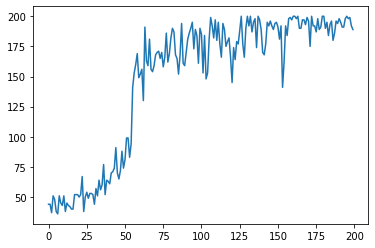

In [14]:
myparams = Params(model_name = "A2C", env_name='CartPole-v0',solved_at=200,num_episodes=2000)
mytrainer = Trainer(myparams)
mytrainer.play_and_train()
mytrainer.plot_Data()

PPO Trainer

Episode 10 	 avg length: 24 	 reward: 25
Episode 20 	 avg length: 25 	 reward: 26
Episode 30 	 avg length: 25 	 reward: 26
Episode 40 	 avg length: 38 	 reward: 39
Episode 50 	 avg length: 37 	 reward: 38
Episode 60 	 avg length: 38 	 reward: 39
Episode 70 	 avg length: 41 	 reward: 42
Episode 80 	 avg length: 55 	 reward: 56
Episode 90 	 avg length: 43 	 reward: 44
Episode 100 	 avg length: 71 	 reward: 72
Episode 110 	 avg length: 75 	 reward: 76
Episode 120 	 avg length: 107 	 reward: 108
Episode 130 	 avg length: 81 	 reward: 82
Episode 140 	 avg length: 112 	 reward: 113
Episode 150 	 avg length: 104 	 reward: 105
Episode 160 	 avg length: 115 	 reward: 116
Episode 170 	 avg length: 159 	 reward: 160
Episode 180 	 avg length: 140 	 reward: 141
Episode 190 	 avg length: 127 	 reward: 128
Episode 200 	 avg length: 163 	 reward: 164
Episode 210 	 avg length: 127 	 reward: 128
Episode 220 	 avg length: 178 	 reward: 179
Episode 230 	 avg length: 172 	 reward: 173
Episode 240 	 avg len

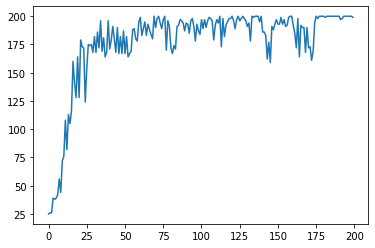

In [16]:
myparams = Params(model_name = "PPO", env_name='CartPole-v0',solved_at=200,num_episodes=2000)
mytrainer = Trainer(myparams)
mytrainer.play_and_train()
mytrainer.plot_Data()